# __EXAMPLE__ (cifar_10, vgg16, ...)

Description & tasks

In [81]:
import itertools
import math 
import os
import random
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import losses
from keras import metrics
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split


- https://www.w3schools.com/python/ref_random_seed.asp

In [82]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)  # 42 from The Hitchhiker's Guide to the Galaxy ^_^

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

#### prepare...

- https://www.tensorflow.org/datasets/catalog/cifar10
- https://www.cs.toronto.edu/~kriz/cifar.html
- https://github.com/YoongiKim/CIFAR-10-images

In [73]:
PATH_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'train')
PATH_TEST_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'test')

cfg = {
       'train_limit': 500,  # limit 500 for each - for example
       'image_size': 32,
       'batch_size': 256,
       }

In [74]:
ids, ids_test = [], []  # full image paths
labels, labels_test = [], []  # true mark 'images name-description' by label2index:
label2index = {}

for num, folder in enumerate(os.listdir(PATH_IMGS)):
    label2index[folder] = num
    train_heap = os.listdir(os.path.join(PATH_IMGS, folder)) if cfg.get('train_limit') == 0 else os.listdir(os.path.join(PATH_IMGS, folder))[:cfg.get('train_limit')]
    for image_name in train_heap:  
        ids.append(os.path.join(PATH_IMGS, folder, image_name))
        labels.append(label2index[folder])

cfg['num_classes'] = num + 1
cfg.get('num_classes')

10

In [75]:
len(ids), len(labels)

(5000, 5000)

In [76]:
for num, folder in enumerate(os.listdir(PATH_TEST_IMGS)):
    test_heap = os.listdir(os.path.join(PATH_TEST_IMGS, folder)) if cfg.get('test_limit') == 0 else os.listdir(os.path.join(PATH_TEST_IMGS, folder))[:cfg.get('test_limit')]
    for image_name in test_heap:  
        ids_test.append(os.path.join(PATH_TEST_IMGS, folder, image_name))
        labels_test.append(label2index[folder])  # .get?

In [77]:
len(ids_test), len(labels_test)

(10000, 10000)

In [78]:
label2index

{'dog': 0,
 'ship': 1,
 'frog': 2,
 'automobile': 3,
 'bird': 4,
 'deer': 5,
 'truck': 6,
 'cat': 7,
 'airplane': 8,
 'horse': 9}

In [79]:
index2label = {y: x for x, y in label2index.items()}
index2label

{0: 'dog',
 1: 'ship',
 2: 'frog',
 3: 'automobile',
 4: 'bird',
 5: 'deer',
 6: 'truck',
 7: 'cat',
 8: 'airplane',
 9: 'horse'}

In [80]:
ids_train, ids_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, shuffle=True)
len(ids_train), len(ids_valid), len(y_train), len(y_valid)

(4000, 1000, 4000, 1000)

- https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
- https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

- https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html
- https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/

In [11]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, ids: list, y: list, num_classes: int, to_size: int, shuffle: bool=True, batch_size: int=256) -> None:
        self.ids = ids  # list of imgs path
        self.y = y  # list of labels ids (List[int])
        self.num_classes = num_classes
        self.to_size = to_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.ids))
        self.batch_size = batch_size
        self.num_features = self.num_features if self.__getitem__(0) else 0
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self) -> int:
        return len(self.ids) // self.batch_size
    
    def __getitem__(self, idx: int) -> tuple:  # get one batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_ids = [self.ids[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], self.num_classes) for i in indexes]
        
        batch_X = []
        for i in range(self.batch_size):
            img = cv2.imread(batch_ids[i])  # i/o disk operation! but low RAM uses
            # img = np.mean(img, axis=-1)  # RGB to grayscale
            # img = np.mean(img, cv2.COLOR_BGR2RGB, axis=-1)  # RGB to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            batch_X.append(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST))
            # batch_X.append(cv2.cvtColor(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB))
        
        self.num_features = len(img[0]) * len(img) # !!
        
        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self) -> None:
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [92]:
train_dataset = Dataset(ids_train, y_train, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=True, batch_size=cfg.get('batch_size'))
X, y = train_dataset[0]
X.shape, y.shape

((256, 32, 32, 3), (256, 10))

In [93]:
test_dataset = Dataset(ids_test, labels_test, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=True, batch_size=cfg.get('batch_size'))
X_test, y_test = test_dataset[0]
X_test.shape, y_test.shape

((256, 32, 32, 3), (256, 10))

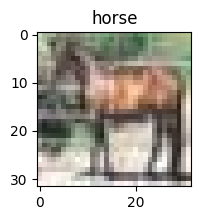

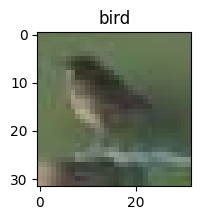

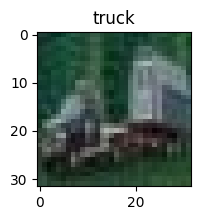

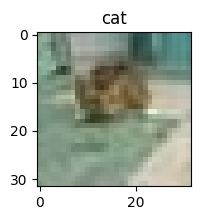

In [95]:
for i in range(4):
    plt.figure(figsize=(2, 2))
    plt.title(index2label[np.where(y[i] == 1)[0][0]])
    # plt.imshow(X[i].reshape(32, 32))
    plt.imshow(X[i])
    plt.show()

In [96]:
# train_dataset = Dataset(ids_train, y_train, shuffle=True, batch_size=cfg.get('batch_size'))
# train_dataset[0]
cfg['num_features'] = train_dataset.num_features
cfg.get('num_features')

1024

In [97]:
valid_dataset = Dataset(ids_valid, y_valid, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=False, batch_size=cfg.get('batch_size'))

In [98]:
valid_dataset[0][0].shape  # (batch_size, num_features)

(256, 32, 32, 3)

#### fix Pre-preparation

In [83]:
PATH_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'train')
PATH_TEST_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'test')

cfg = {
       'train_limit': 500,  # limit 500 for each - for example
       'image_size': 32,
       'batch_size': 256,
       'epochs_limit': 100,
       'filter': 256,
       }

label2index = {}

In [84]:
ids, ids_test = [], []  # full image paths
labels, labels_test = [], []  # true mark 'images name-description' by label2index:


for num, folder in enumerate(os.listdir(PATH_IMGS)):
    label2index[folder] = num
    train_heap = os.listdir(os.path.join(PATH_IMGS, folder)) if cfg.get('train_limit') == 0 else os.listdir(os.path.join(PATH_IMGS, folder))[:cfg.get('train_limit')]
    for image_name in train_heap:  
        ids.append(os.path.join(PATH_IMGS, folder, image_name))
        labels.append(label2index[folder])

cfg['num_classes'] = num + 1
cfg.get('num_classes')

10

In [85]:
def pre_preparation_data(path_imgs: str, path_test_imgs: str) -> tuple:
    train_limit = cfg.get('train_limit')
    test_size = cfg.get('test_limit')
    ids, ids_test = [], []  # full image paths
    labels, labels_test = [], []  # true mark 'images name-description' by label2index:
    for num, folder in enumerate(os.listdir(path_imgs)):
        label2index[folder] = num
        train_heap = os.listdir(os.path.join(path_imgs, folder)) if train_limit == 0 else os.listdir(os.path.join(path_imgs, folder))[:train_limit]
        for image_name in train_heap:  
            ids.append(os.path.join(path_imgs, folder, image_name))
            labels.append(label2index[folder])
    
    cfg['num_classes'] = num + 1

    for num, folder in enumerate(os.listdir(path_test_imgs)):
        test_heap = os.listdir(os.path.join(path_test_imgs, folder)) if test_size == 0 else os.listdir(os.path.join(path_test_imgs, folder))[:test_size]
        for image_name in test_heap:  
            ids_test.append(os.path.join(path_test_imgs, folder, image_name))
            labels_test.append(label2index[folder])  # .get?         

    ids_train, _, y_train, __ = train_test_split(ids, labels, test_size=0.0001, shuffle=True)
    ids_valid, ids_test, y_valid, y_test = train_test_split(ids_test, labels_test, test_size=0.5, shuffle=True)   

    return ids_train, y_train, ids_valid, y_valid, ids_test, y_test

In [86]:
ids_train, labels_train, ids_valid, labels_valid, ids_test, labels_test = pre_preparation_data(PATH_IMGS, PATH_TEST_IMGS)
len(ids_train), len(labels_train), len(ids_valid), len(labels_valid), len(ids_test), len(labels_test)

(4999, 4999, 5000, 5000, 5000, 5000)

train_limit(500) * num_classes(10) = size(5000)

In [87]:
cfg.get('num_classes')

10

In [88]:
label2index

{'dog': 0,
 'ship': 1,
 'frog': 2,
 'automobile': 3,
 'bird': 4,
 'deer': 5,
 'truck': 6,
 'cat': 7,
 'airplane': 8,
 'horse': 9}

In [89]:
index2label = {y: x for x, y in label2index.items()}
index2label

{0: 'dog',
 1: 'ship',
 2: 'frog',
 3: 'automobile',
 4: 'bird',
 5: 'deer',
 6: 'truck',
 7: 'cat',
 8: 'airplane',
 9: 'horse'}

In [90]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, ids: list, y: list, num_classes: int, to_size: int, shuffle: bool=True, batch_size: int=256) -> None:
        self.ids = ids  # list of imgs path
        self.y = y  # list of labels ids (List[int])
        self.num_classes = num_classes
        self.to_size = to_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.ids))
        self.batch_size = batch_size
        self.num_features = self.num_features if self.__getitem__(0) else 0
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self) -> int:
        return len(self.ids) // self.batch_size
    
    def __getitem__(self, idx: int) -> tuple:  # get one batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_ids = [self.ids[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], self.num_classes) for i in indexes]
        
        batch_X = []
        for i in range(self.batch_size):
            img = cv2.imread(batch_ids[i])  # i/o disk operation! but low RAM uses
            # img = np.mean(img, axis=-1)  # RGB to grayscale
            # img = np.mean(img, cv2.COLOR_BGR2RGB, axis=-1)  # RGB to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            batch_X.append(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST))
            # batch_X.append(cv2.cvtColor(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB))
        
        self.num_features = len(img[0]) * len(img) # !!
        
        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self) -> None:
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [91]:
train_dataset = Dataset(ids_train, labels_train, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=True, batch_size=cfg.get('batch_size'))
valid_dataset = Dataset(ids_valid, labels_valid, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=False, batch_size=cfg.get('batch_size'))
test_dataset = Dataset(ids_test, labels_test, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=True, batch_size=cfg.get('batch_size'))
X_test, y_test = test_dataset[0]
X_test.shape, y_test.shape, valid_dataset[0][0].shape, valid_dataset[0][1].shape, test_dataset[0][0].shape, test_dataset[0][1].shape

((256, 32, 32, 3),
 (256, 10),
 (256, 32, 32, 3),
 (256, 10),
 (256, 32, 32, 3),
 (256, 10))

In [92]:
cfg['num_features'] = train_dataset.num_features
cfg.get('num_features')

1024

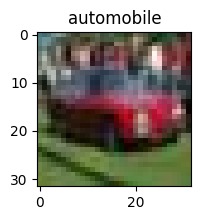

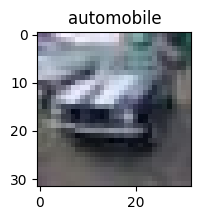

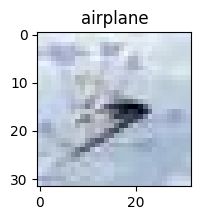

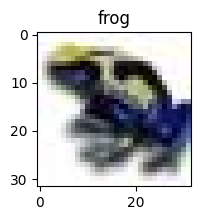

In [93]:
for i in range(4):
    plt.figure(figsize=(2, 2))
    plt.title(index2label[np.where(y_test[i] == 1)[0][0]])
    # plt.imshow(X[i].reshape(32, 32))
    plt.imshow(X_test[i])
    plt.show()

In [94]:
# train_dataset, valid_dataset, test_dataset

In [73]:
def create_dataset_directories(base_dir: str) -> None:
    print('Start creation of dataset directories...')

    os.mkdir(base_dir) if not os.path.exists(base_dir) else None

    sub_dir = os.path.join(base_dir, 'validation')
    os.mkdir(sub_dir)

    for key in label2index:
        os.mkdir(os.path.join(sub_dir, key))

    print('Done')


# move ?
def copy_data(
              src: str, dst: str, start: int, end: int
              ) -> None:
    for num, fname in enumerate(os.listdir(src)):
        if num >= start and num <= end:
            shutil.copyfile(
                            os.path.join(src, fname),
                            os.path.join(dst, fname)
                            )

create_dataset_directories(os.path.join(os.getcwd(), 'CIFAR-10-images-master'))

for key in label2index:
    edge = len(next(os.walk(os.path.join(PATH_TEST_IMGS, key)))[2])
    copy_data(os.path.join(PATH_TEST_IMGS, key), os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'validation', key), edge // 2, edge)


Start creation of dataset directories...
Done


In [95]:
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                                                    PATH_IMGS,
                                                    target_size=(cfg.get('image_size'), cfg.get('image_size')),
                                                    batch_size=cfg.get('batch_size'),
                                                    class_mode='categorical'
                                                    )

validation_generator = valid_datagen.flow_from_directory(
                                                         os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'validation'),
                                                         target_size=(cfg.get('image_size'), cfg.get('image_size')),
                                                         batch_size=cfg.get('batch_size'),
                                                         class_mode='categorical'
                                                         )

test_generator = test_datagen.flow_from_directory(
                                                  PATH_TEST_IMGS,
                                                  target_size=(cfg.get('image_size'), cfg.get('image_size')),
                                                  batch_size=cfg.get('batch_size'),
                                                  class_mode='categorical'
                                                  )

Found 50000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [96]:
train_generator.samples, validation_generator.samples, test_generator.samples

(50000, 5000, 10000)

### __`MODEL`__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
- https://keras.io/api/layers/regularization_layers/dropout/

#### prepare for creating model

In [98]:
# train_dataset[0][0].shape[1], ...
(X_test.shape[1], X_test.shape[2], X_test.shape[3])
# (cfg.get('image_size'), cfg.get('image_size'), 3)

(32, 32, 3)

In [99]:
conv_base = VGG16(
                  weights='imagenet',  # джерело ваги для ініціалізації моделі
                  include_top=False,   # визначає необхідність підключення до повнозв'язкового класифікатора, який відповідає 1000 класів з ImageNet.
                  input_shape=(cfg.get('image_size'), cfg.get('image_size'), 3)  # визначає форму тензорів із зображеннями, які подаватимуться на вхід мережі. 
                    # Це необов'язковий аргумент, тому якщо його прибрати, то мережа зможе обробляти зображення будь-якого розміру.
                  )

conv_base.trainable = False  # відключається навчання шару.

model = models.Sequential([
                            conv_base,
                            layers.Flatten(),
                            # layers.Dropout(0.5),
                            layers.Dense(cfg.get('filter'), activation='relu'),
                            layers.Dense(cfg.get('num_classes'), activation='softmax'),
                            ])

model.compile(
                loss=losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
                metrics=[metrics.CategoricalAccuracy()]
                )


In [100]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


#### __`Training`__

- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [101]:
callback_early_stopping = EarlyStopping(
                                        monitor='val_categorical_accuracy',  # val_loss
                                        patience=4,
                                        )

callback_save = ModelCheckpoint(
                                'best.hdf5',  # name to save the resulting model
                                monitor='val_loss',
                                save_best_only=True,
                                )

In [102]:
history_1 = model.fit(
                      train_generator,
                      steps_per_epoch=train_generator.samples / cfg.get('batch_size'),
                      epochs=cfg.get('epochs_limit'),
                      validation_data=validation_generator,
                      validation_steps=validation_generator.samples / cfg.get('batch_size'),
                      callbacks=[callback_early_stopping, callback_save]
                      )

Epoch 1/100
195/195 [==============================] - 148s 756ms/step - loss: 1.9175 - categorical_accuracy: 0.3344 - val_loss: 1.6849 - val_categorical_accuracy: 0.4224
Epoch 2/100


/home/denys/.cache/pypoetry/virtualenvs/datas-cYPLqW4U-py3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


195/195 [==============================] - 149s 761ms/step - loss: 1.6826 - categorical_accuracy: 0.4128 - val_loss: 1.5455 - val_categorical_accuracy: 0.4634
Epoch 3/100
195/195 [==============================] - 147s 751ms/step - loss: 1.6123 - categorical_accuracy: 0.4380 - val_loss: 1.4945 - val_categorical_accuracy: 0.4786
Epoch 4/100
195/195 [==============================] - 147s 753ms/step - loss: 1.5759 - categorical_accuracy: 0.4506 - val_loss: 1.4574 - val_categorical_accuracy: 0.4970
Epoch 5/100
195/195 [==============================] - 147s 751ms/step - loss: 1.5431 - categorical_accuracy: 0.4620 - val_loss: 1.4390 - val_categorical_accuracy: 0.4996
Epoch 6/100
195/195 [==============================] - 147s 751ms/step - loss: 1.5247 - categorical_accuracy: 0.4663 - val_loss: 1.4034 - val_categorical_accuracy: 0.5100
Epoch 7/100
195/195 [==============================] - 147s 752ms/step - loss: 1.5089 - categorical_accuracy: 0.4739 - val_loss: 1.4093 - val_categorical_acc

In [103]:
callback_save2 = ModelCheckpoint(
                                 'best2.hdf5',  # name to save the resulting model
                                 monitor='val_loss',
                                 save_best_only=True,
                                 )

In [104]:
history_2 = model.fit(
                    train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=cfg.get('epochs_limit'),
                    validation_data=valid_dataset,
                    validation_steps=len(valid_dataset),
                    # verbose=1, # print logs
                    callbacks=[callback_early_stopping, callback_save2]
                    )

Epoch 1/100


19/19 [==============================] - 22s 1s/step - loss: 114.8362 - categorical_accuracy: 0.0898 - val_loss: 91.2241 - val_categorical_accuracy: 0.1003
Epoch 2/100
19/19 [==============================] - 22s 1s/step - loss: 76.2381 - categorical_accuracy: 0.1063 - val_loss: 64.0778 - val_categorical_accuracy: 0.1287
Epoch 3/100
19/19 [==============================] - 22s 1s/step - loss: 53.4284 - categorical_accuracy: 0.1443 - val_loss: 45.9109 - val_categorical_accuracy: 0.1593
Epoch 4/100
19/19 [==============================] - 22s 1s/step - loss: 38.5359 - categorical_accuracy: 0.1871 - val_loss: 34.1550 - val_categorical_accuracy: 0.1990
Epoch 5/100
19/19 [==============================] - 22s 1s/step - loss: 28.4263 - categorical_accuracy: 0.2391 - val_loss: 26.3330 - val_categorical_accuracy: 0.2467
Epoch 6/100
19/19 [==============================] - 22s 1s/step - loss: 21.8509 - categorical_accuracy: 0.2930 - val_loss: 21.1194 - val_categorical_accuracy: 0.2915
Epoch 7/1

In [105]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    plt.show()

In [106]:
# def test_NN(
#             train_dataset: Dataset, 
#             valid_dataset: Dataset, 
#             set_layers: list, 
#             act: list, 
#             opt: optimizers, 
#             lr: float,  
#             epochs: int=100
#             ) -> None:
#     """For test one model."""
#     model = create_NN(
#                       n_hidden_=set_layers, 
#                       activation=act, 
#                       optimizer=opt, 
#                       learning_rate=lr
#                       )

#     history = model.fit(
#                         train_dataset,
#                         validation_data=valid_dataset,
#                         epochs=epochs,
#                         verbose=1, # print logs
#                         callbacks=[callback_early_stopping]  # callback_save
#                         )

#     loss_values = history.history['loss']
#     val_loss_values = history.history['val_loss']
#     acc_values = history.history['categorical_accuracy']
#     val_acc_values = history.history['val_categorical_accuracy']   

#     draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=f'{model.name}({train_dataset.batch_size})')

In [107]:
# train_dataset.batch_size

In [108]:
# test_NN(
#         train_dataset=train_dataset,
#         valid_dataset=valid_dataset,
#         set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
#         act=['relu', 'relu', 'softmax'], 
#         opt=optimizers.legacy.Adam, 
#         lr=0.001,
#         epochs=100
#         )

### __`INTERPRET`__ / __`Error Analysis`__

In [109]:
# draw

### __`RE-TEST`__

In [110]:
# deploy...

### __`RESULTS` & `CONCLUSIONS`__